# 【問題1】train_test_splitのスクラッチ

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
a = np.array([1, 1, 1, 2, 2, 2, 3, 3])
b = np.array([0, 0, 1, 1, 1, 0, 0, 0])

In [3]:
np.random.seed(0)
print(np.random.permutation(10))
print(np.random.permutation(b))

[2 8 4 9 1 6 7 3 0 5]
[1 0 1 0 0 0 0 1]


In [4]:
np.bincount(a)

array([0, 3, 3, 2], dtype=int64)

In [5]:
np.argsort(b, kind='mergesort')

array([0, 1, 5, 6, 7, 2, 3, 4], dtype=int64)

In [6]:
np.cumsum(np.bincount(a))[:-1]

array([0, 3, 6], dtype=int64)

In [7]:
np.split(np.argsort(b, kind='mergesort'),np.cumsum(np.bincount(a))[:-1])

[array([], dtype=int64),
 array([0, 1, 5], dtype=int64),
 array([6, 7, 2], dtype=int64),
 array([3, 4], dtype=int64)]

In [8]:
for i in range(np.unique(a).shape[0] + 1):
    print(np.random.RandomState(0).permutation(np.bincount(a)[i]))

[]
[2 1 0]
[2 1 0]
[1 0]


In [9]:
for i in range(np.unique(a).shape[0] + 1):
    print(np.split(np.argsort(b, kind='mergesort'),np.cumsum(np.bincount(a))[:-1])[i].take(np.random.RandomState(0).permutation(np.bincount(a)[i])))

[]
[5 1 0]
[2 7 6]
[4 3]


In [10]:
f = [1,2,3]

In [11]:
def scratch_train_test_split(X, y, train_size=0.8, random_state=None, shuffle=True, stratify=None):
    """
    検証データを分割する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, )
      正解値
    train_size : float (0<train_size<1)
      何割をtrainとするか指定
    random_state : int
      乱数生成のシードとなる整数
    shuffle : boolean
      分割する前のデータをシャッフルするかどうか
    stratify : ndarray, shape (n_samples, )
      サンプルの割合を一定にするかどうか

    Returns
    ----------
    X_train : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    X_test : 次の形のndarray, shape (n_samples, n_features)
      検証データ
    y_train : 次の形のndarray, shape (n_samples, )
      訓練データの正解値
    y_test : 次の形のndarray, shape (n_samples, )
      検証データの正解値
    """

    n_samples = X.shape[0]
    n_train = np.floor(train_size * n_samples).astype(int)
    n_test = n_samples - n_train

    if shuffle == False and stratify is None:
        X_train = X[:n_train]
        X_test = X[n_train:(n_train + n_test)]
        y_train = y[:n_train]
        y_test = y[n_train:(n_train + n_test)]

        yield X_train
        yield X_test
        yield y_train
        yield y_test

    elif shuffle == True and stratify is None:
        rng = np.random.RandomState(seed=random_state)
        permutation = rng.permutation(n_samples)
        train_index = permutation[:n_train]
        test_index = permutation[n_train:(n_train + n_test)]
        
        if type(X) == np.ndarray and type(y) == np.ndarray:
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]
        else:
            X_train = X.iloc[train_index]
            X_test = X.iloc[test_index]
            y_train = y.iloc[train_index]
            y_test = y.iloc[test_index]
            
        yield X_train
        yield X_test
        yield y_train
        yield y_test

    elif shuffle == True and stratify is not None:
        classes, y_indices = np.unique(y, return_inverse=True)
        n_classes = classes.shape[0]
        class_counts = np.bincount(y_indices)
        # yを大きさの順番でインデックスをつけ、それをXのクラスの数ごとに分割してリストに入れる
        class_indices = np.split(np.argsort(y_indices, kind='mergesort'),np.cumsum(class_counts)[:-1])
        if np.min(class_counts) < 2:
            raise ValueError("The least populated class in y has only 1"
                             " member, which is too few. The minimum"
                             " number of groups for any class cannot"
                             " be less than 2.")
        if n_train < n_classes:
            raise ValueError('The train_size = %d should be greater or '
                             'equal to the number of classes = %d' %
                             (n_train, n_classes))
        if n_test < n_classes:
            raise ValueError('The test_size = %d should be greater or '
                             'equal to the number of classes = %d' %
                             (n_test, n_classes))
            
        rng = np.random.RandomState(seed=random_state)
        n_i = _approximate_mode(class_counts, n_train, rng)
        class_counts_remaining = class_counts - n_i
        t_i = _approximate_mode(class_counts_remaining, n_test, rng)

        train = []
        test = []

        for i in range(n_classes):
            # それぞれのクラスを並べかえている
            permutation = rng.permutation(class_counts[i])
            # yのindexを上で作った順序にそれぞれのリスト内で並べ替える
            perm_indices_class_i = class_indices[i].take(permutation,mode='clip')
            train.extend(perm_indices_class_i[:n_i[i]])
            test.extend(perm_indices_class_i[n_i[i]:n_i[i] + t_i[i]])

        train_index = rng.permutation(train)
        test_index = rng.permutation(test)

        if type(X) == np.ndarray and type(y) == np.ndarray:
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]
        else:
            X_train = X.iloc[train_index]
            X_test = X.iloc[test_index]
            y_train = y.iloc[train_index]
            y_test = y.iloc[test_index]
            
        yield X_train
        yield X_test
        yield y_train
        yield y_test

def _approximate_mode(class_counts, n_draws, rng):
    """
    class_countsからn_drawsだけとってきたときに
    それぞれの要素をいくつ取ってくるかを返す関数

    class_counts : ndarray of int
        それぞれのクラスの数
    n_draws : int
        どれだけ取ってくるかの総数
    rng : random state
        numpy.random.RandomState()
    Returns
    -------
    sampled_classes : ndarray of int
        それぞれのクラスからとったきた数
        np.sum(sampled_classes) == n_draws

    """
    continuous = n_draws * (class_counts / class_counts.sum())
    floored = np.floor(continuous)
    need_to_add = int(n_draws - floored.sum())
    if need_to_add > 0:
        remainder = continuous - floored
        values = np.sort(np.unique(remainder))[::-1]
        for value in values:
            inds = np.where(remainder == value)
            add_now = min(len(inds), need_to_add)
            inds = rng.choice(inds, size=add_now, replace=False)
            floored[inds] += 1
            need_to_add -= add_now
            if need_to_add == 0:
                break
    return floored.astype(np.int)

## irisデータでスクラッチできたか確認

In [12]:
from sklearn.datasets import load_iris

In [13]:
data = load_iris()

In [14]:
X = pd.DataFrame(data=data['data'],columns=data['feature_names'])

In [15]:
y = pd.DataFrame(data=data['target'], columns=['Species'])

## 条件：shuffle=False, stratify=None

In [16]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = scratch_train_test_split(X, y, train_size=0.8, random_state=0, 
                                                                        shuffle=False, stratify=None)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=False, stratify=None)

In [18]:
if X_train_sc.equals(X_train) and X_test_sc.equals(X_test) and y_train_sc.equals(y_train) and y_test_sc.equals(y_test):
    print('OK')

OK


## 条件：shuffle=True, stratify=None

In [19]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = scratch_train_test_split(X, y, train_size=0.8, random_state=0, 
                                                                        shuffle=True, stratify=None)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [21]:
if X_train_sc.equals(X_train) and X_test_sc.equals(X_test) and y_train_sc.equals(y_train) and y_test_sc.equals(y_test):
    print('OK')

In [22]:
display(X_train_sc, X_train)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
114,5.8,2.8,5.1,2.4
62,6.0,2.2,4.0,1.0
33,5.5,4.2,1.4,0.2
107,7.3,2.9,6.3,1.8
7,5.0,3.4,1.5,0.2
...,...,...,...,...
57,4.9,2.4,3.3,1.0
131,7.9,3.8,6.4,2.0
65,6.7,3.1,4.4,1.4
32,5.2,4.1,1.5,0.1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
137,6.4,3.1,5.5,1.8
84,5.4,3.0,4.5,1.5
27,5.2,3.5,1.5,0.2
127,6.1,3.0,4.9,1.8
132,6.4,2.8,5.6,2.2
...,...,...,...,...
9,4.9,3.1,1.5,0.1
103,6.3,2.9,5.6,1.8
67,5.8,2.7,4.1,1.0
117,7.7,3.8,6.7,2.2


## testを先に分けているか、trainを先に分けているかで、分かれたデータが異なるが、やりたいことはできていると考える

## 条件：shuffle=True, stratify=y

In [23]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = scratch_train_test_split(X, y, train_size=0.8, random_state=0, 
                                                                        shuffle=True, stratify=y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True, stratify=y)

In [25]:
if X_train_sc.equals(X_train) and X_test_sc.equals(X_test) and y_train_sc.equals(y_train) and y_test_sc.equals(y_test):
    print('OK')

OK


# 【問題2】 分類問題を解くコードの作成

## データセットの用意

In [26]:
X_iris = X[50:]
y_iris = y[50:]
y_iris[y_iris==2] = 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\pandas\core\frame.py:3530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [27]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X_1 = X[random_index]
y_1 = y[random_index]

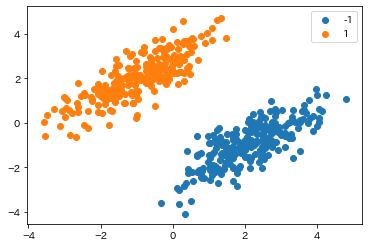

In [28]:
plt.scatter(X_1[y_1==-1][:,0], X_1[y_1==-1][:,1],label='-1')
plt.scatter(X_1[y_1==1][:,0], X_1[y_1==1][:,1], label='1')
plt.legend()

In [29]:
X_2 = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y_2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

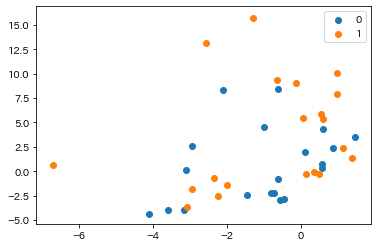

In [30]:
plt.scatter(X_2[y_2==0][:,0], X_2[y_2==0][:,1],label='0')
plt.scatter(X_2[y_2==1][:,0], X_2[y_2==1][:,1], label='1')
plt.legend()

## ロジスティック回帰

In [31]:
def calculate_accuracy_score(X, y, model):
    X_train, X_validation, y_train, y_validation = scratch_train_test_split(X, y, train_size=0.8, random_state=0,
                                                                            shuffle=True, stratify=True)
    ss = StandardScaler()
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_validation = ss.transform(X_validation)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    score = accuracy_score(y_validation, y_pred)
    
    return score

In [32]:
from sklearn.linear_model import SGDClassifier

In [33]:
calculate_accuracy_score(X_iris, y_iris, SGDClassifier(loss='log'))

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [34]:
calculate_accuracy_score(X_1, y_1, SGDClassifier(loss='log'))

1.0

In [35]:
calculate_accuracy_score(X_2, y_2, SGDClassifier(loss='log'))

0.5

## データセット２の分布は直線では分類ができないので、ロジスティック回帰では分類ができず、accuracy_scoreが低くなった。

## SVM

In [36]:
from sklearn.svm import SVC

In [37]:
calculate_accuracy_score(X_iris, y_iris, SVC())

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.95

In [38]:
calculate_accuracy_score(X_1, y_1, SVC())

1.0

In [39]:
calculate_accuracy_score(X_2, y_2, SVC())

0.5

## 決定木

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
calculate_accuracy_score(X_iris, y_iris, DecisionTreeClassifier())

0.95

In [42]:
calculate_accuracy_score(X_1, y_1, DecisionTreeClassifier())

1.0

In [43]:
calculate_accuracy_score(X_2, y_2, DecisionTreeClassifier())

0.625

# 【問題3】 回帰問題を解くコードの作成

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
def calculate_rmse(X, y, model):
    X_train, X_validation, y_train, y_validation = scratch_train_test_split(X, y, train_size=0.8, random_state=0, 
                                                                            shuffle=False, stratify=None)
    ss = StandardScaler()
    ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_validation = ss.transform(X_validation)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
    
    return rmse

In [46]:
from sklearn.linear_model import SGDRegressor

In [47]:
train = pd.read_csv('train.csv')

In [48]:
X_house = train[['GrLivArea', 'YearBuilt']]

In [49]:
y_house = train['SalePrice']

In [50]:
calculate_rmse(X_house, y_house, SGDRegressor())

54430.37928755447